In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.dpi'] = 600

base_path = '/Users/weilynnw/Documents/GitHub/CEE690-ESAA/assignment_2_data'

 # UTILITY FUNCTIONS

In [3]:

def circular_day_difference(day1, day2, year_length=365):
    """
    Calculate smallest circular difference between two days of water year.
    Implements Tip 2 from assignment.
    
    Example: Dec 31 (day 365) to Jan 1 (day 1) = 1 day, not 364 days
    """
    diff = day2 - day1
    
    # Find shortest path around the circle
    if abs(diff) > year_length / 2:
        if diff > 0:
            diff = diff - year_length
        else:
            diff = diff + year_length
    
    return diff

def get_day_of_water_year(date):
    """
    Convert date to day of water year (1-365)
    Water year starts Oct 1
    """
    if date.month >= 10:
        wy_start = pd.Timestamp(date.year, 10, 1)
    else:
        wy_start = pd.Timestamp(date.year - 1, 10, 1)
    
    return (date - wy_start).days + 1

def add_water_year(df):
    """Add water year column (Oct-Sep)"""
    df['water_year'] = df['date'].apply(
        lambda x: x.year if x.month < 10 else x.year + 1
    )
    return df

# Load and preprocess reservoir data

In [4]:
def load_and_preprocess(filepath):
    df = pd.read_csv(filepath)
    
    # Rename columns for consistency
    df = df.rename(columns={
        'datetime': 'date',
        'inflow_cfs': 'inflow',
        'outflow_cfs': 'outflow'
    })
    
    df['date'] = pd.to_datetime(df['date'])
    
    # Remove Feb 29 from leap years (Tip 1)
    df = df[~((df['date'].dt.month == 2) & (df['date'].dt.day == 29))].copy()
    
    df = add_water_year(df)
    
    df = df.sort_values('date').reset_index(drop=True)
    
    return df

 # INDICATOR CALCULATIONS

In [5]:
def calculate_indicator_a(df):
    """
    (a) Percent change of average annual alteration of 3-day peak flow
    Formula: 100 * (Xout - Xin) / Xin
    """
    results = []
    
    for wy in sorted(df['water_year'].unique()):
        # Get data for this water year
        wy_data = df[df['water_year'] == wy]
        
        if len(wy_data) < 3:
            continue
        
        # Calculate 3-day rolling average peak
        in_3day_peak = wy_data['inflow'].rolling(window=3, center=False).mean().max()
        out_3day_peak = wy_data['outflow'].rolling(window=3, center=False).mean().max()
        
        # Calculate percent change
        pct_change = 100 * (out_3day_peak - in_3day_peak) / in_3day_peak
        
        results.append({
            'water_year': wy,
            'in_3day_peak': in_3day_peak,
            'out_3day_peak': out_3day_peak,
            'pct_change': pct_change
        })
    
    return pd.DataFrame(results)

def calculate_indicator_b(df):
    """
    (b) Percent change of average annual alteration of 31-day low flow
    """
    results = []
    
    for wy in sorted(df['water_year'].unique()):
        wy_data = df[df['water_year'] == wy]
        
        if len(wy_data) < 31:
            continue
        
        # Calculate 31-day rolling average minimum
        in_31day_low = wy_data['inflow'].rolling(window=31, center=False).mean().min()
        out_31day_low = wy_data['outflow'].rolling(window=31, center=False).mean().min()
        
        # Calculate percent change
        pct_change = 100 * (out_31day_low - in_31day_low) / in_31day_low
        
        results.append({
            'water_year': wy,
            'in_31day_low': in_31day_low,
            'out_31day_low': out_31day_low,
            'pct_change': pct_change
        })
    
    return pd.DataFrame(results)

def calculate_indicator_c(df):
    """
    (c) Timing (day of water year) of 3-day peak flow
    Returns: circular difference in days (outflow - inflow timing)
    """
    results = []
    
    for wy in sorted(df['water_year'].unique()):
        wy_data = df[df['water_year'] == wy].copy()
        
        if len(wy_data) < 3:
            continue
        
        # Calculate 3-day rolling average
        wy_data['in_rolling_3day'] = wy_data['inflow'].rolling(window=3, center=False).mean()
        wy_data['out_rolling_3day'] = wy_data['outflow'].rolling(window=3, center=False).mean()
        
        # Find timing of peak
        in_peak_idx = wy_data['in_rolling_3day'].idxmax()
        out_peak_idx = wy_data['out_rolling_3day'].idxmax()
        
        in_peak_date = wy_data.loc[in_peak_idx, 'date']
        out_peak_date = wy_data.loc[out_peak_idx, 'date']
        
        # Convert to day of water year
        in_day = get_day_of_water_year(in_peak_date)
        out_day = get_day_of_water_year(out_peak_date)
        
        # Calculate circular difference
        timing_diff = circular_day_difference(in_day, out_day)
        
        results.append({
            'water_year': wy,
            'in_timing': in_day,
            'out_timing': out_day,
            'timing_diff': timing_diff
        })
    
    return pd.DataFrame(results)

def calculate_indicator_d(df):
    """
    (d) Timing (day of water year) of 31-day low flow
    """
    results = []
    
    for wy in sorted(df['water_year'].unique()):
        wy_data = df[df['water_year'] == wy].copy()
        
        if len(wy_data) < 31:
            continue
        
        # Calculate 31-day rolling average
        wy_data['in_rolling_31day'] = wy_data['inflow'].rolling(window=31, center=False).mean()
        wy_data['out_rolling_31day'] = wy_data['outflow'].rolling(window=31, center=False).mean()
        
        # Find timing of minimum
        in_low_idx = wy_data['in_rolling_31day'].idxmin()
        out_low_idx = wy_data['out_rolling_31day'].idxmin()
        
        in_low_date = wy_data.loc[in_low_idx, 'date']
        out_low_date = wy_data.loc[out_low_idx, 'date']
        
        # Convert to day of water year
        in_day = get_day_of_water_year(in_low_date)
        out_day = get_day_of_water_year(out_low_date)
        
        # Calculate circular difference
        timing_diff = circular_day_difference(in_day, out_day)
        
        results.append({
            'water_year': wy,
            'in_timing': in_day,
            'out_timing': out_day,
            'timing_diff': timing_diff
        })
    
    return pd.DataFrame(results)

def calculate_indicator_e(df):
    """
    (e) Flashiness (Richards-Baker Index)
    RBI = Σ|Q_i - Q_{i-1}| / ΣQ_i
    """
    results = []
    
    for wy in sorted(df['water_year'].unique()):
        wy_data = df[df['water_year'] == wy]
        
        if len(wy_data) < 2:
            continue
        
        # Calculate RBI for inflow
        in_diff = wy_data['inflow'].diff().abs().sum()
        in_total = wy_data['inflow'].sum()
        in_rbi = in_diff / in_total if in_total > 0 else np.nan
        
        # Calculate RBI for outflow
        out_diff = wy_data['outflow'].diff().abs().sum()
        out_total = wy_data['outflow'].sum()
        out_rbi = out_diff / out_total if out_total > 0 else np.nan
        
        # Difference
        rbi_diff = out_rbi - in_rbi
        
        results.append({
            'water_year': wy,
            'in_rbi': in_rbi,
            'out_rbi': out_rbi,
            'rbi_diff': rbi_diff
        })
    
    return pd.DataFrame(results)

\n================================================================================
RESERVOIR HYDROLOGICAL INDICATORS ANALYSIS
Assignment 2 - CEE690-ESAA

Found 9 reservoir(s):
  - FOL-daily-flows.csv
  - NML-daily-flows.csv
  - DNP-daily-flows.csv
  - PNF-daily-flows.csv
  - CLE-daily-flows.csv
  - SHA-daily-flows.csv
  - EXC-daily-flows.csv
  - ORO-daily-flows.csv
  - BER-daily-flows.csv

Analyzing: FOL
Date range: 2015-10-01 to 2021-09-30
Total days: 2190
Water years: [2016, 2017, 2018, 2019, 2020, 2021]

Results (averaged across 6 water years):
  (a) Avg % change 3-day peak:     -28.72%
  (b) Avg % change 31-day low:      61.79%
  (c) Avg timing diff 3-day:         25.8 days
  (d) Avg timing diff 31-day:        48.2 days
  (e) Avg RBI difference:         -0.1104

Analyzing: NML
Date range: 2015-10-01 to 2021-09-30
Total days: 2190
Water years: [2016, 2017, 2018, 2019, 2020, 2021]

Results (averaged across 6 water years):
  (a) Avg % change 3-day peak:     -10.44%
  (b) Avg % change 

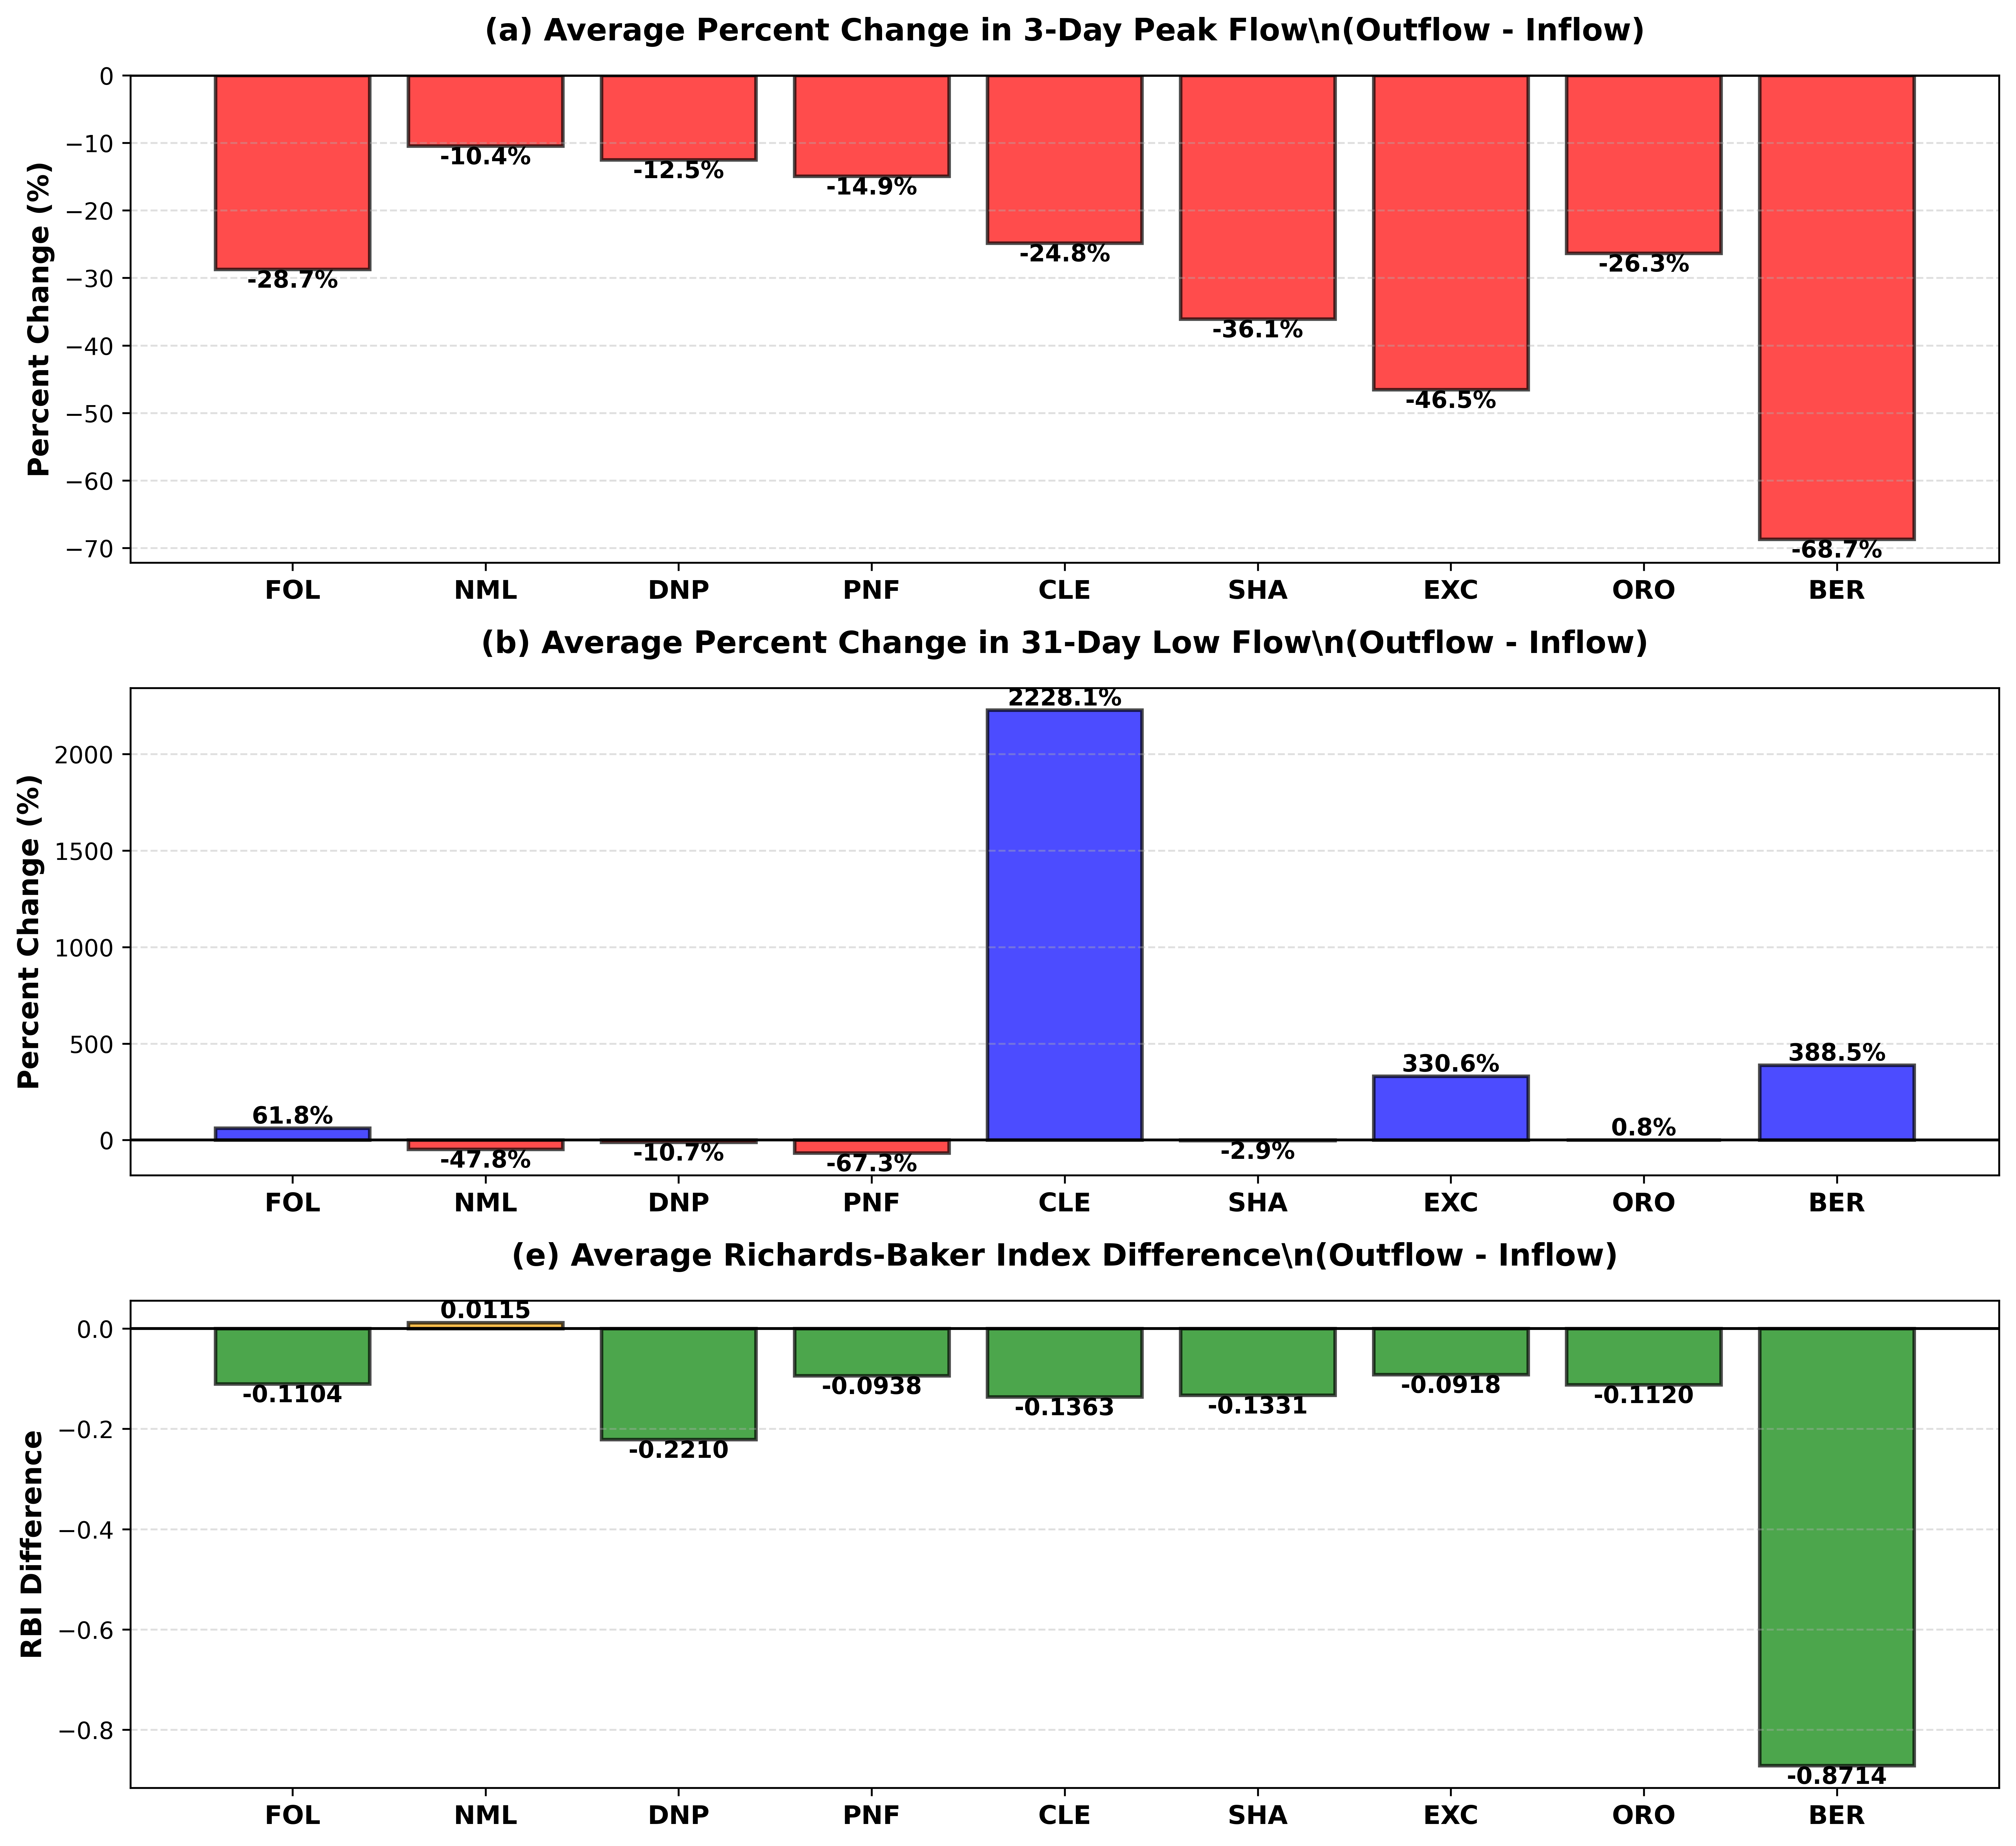

In [6]:
# ANALYSIS FUNCTIONS
def analyze_reservoir(filepath, reservoir_name):
    """
    Analyze a single reservoir
    """
    print(f"\n{'='*60}")
    print(f"Analyzing: {reservoir_name}")
    print(f"{'='*60}")
    
    # Load and preprocess
    df = load_and_preprocess(filepath)
    
    print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
    print(f"Total days: {len(df)}")
    print(f"Water years: {sorted(df['water_year'].unique())}")
    
    # Calculate all indicators
    results = {
        'a_3day_peak_pct': calculate_indicator_a(df),
        'b_31day_low_pct': calculate_indicator_b(df),
        'c_3day_timing': calculate_indicator_c(df),
        'd_31day_timing': calculate_indicator_d(df),
        'e_flashiness': calculate_indicator_e(df)
    }
    
    # Print summary statistics
    print(f"\nResults (averaged across {len(results['a_3day_peak_pct'])} water years):")
    print(f"  (a) Avg % change 3-day peak:   {results['a_3day_peak_pct']['pct_change'].mean():>8.2f}%")
    print(f"  (b) Avg % change 31-day low:   {results['b_31day_low_pct']['pct_change'].mean():>8.2f}%")
    print(f"  (c) Avg timing diff 3-day:     {results['c_3day_timing']['timing_diff'].mean():>8.1f} days")
    print(f"  (d) Avg timing diff 31-day:    {results['d_31day_timing']['timing_diff'].mean():>8.1f} days")
    print(f"  (e) Avg RBI difference:        {results['e_flashiness']['rbi_diff'].mean():>8.4f}")
    
    return results, df

def analyze_multiple_reservoirs(data_dir):
    """
    Analyze all reservoirs in the data directory
    """
    all_results = {}
    
    data_path = Path(data_dir)
    
    # Find all CSV files
    csv_files = list(data_path.glob('*-daily-flows.csv'))
    
    if not csv_files:
        print(f"ERROR: No '*-daily-flows.csv' files found in {data_dir}")
        return None
    
    print(f"\nFound {len(csv_files)} reservoir(s):")
    for f in csv_files:
        print(f"  - {f.name}")
    
    # Analyze each reservoir
    for csv_file in csv_files:
        # Extract reservoir name (e.g., 'BER' from 'BER-daily-flows.csv')
        res_name = csv_file.stem.replace('-daily-flows', '')
        
        results, df = analyze_reservoir(csv_file, res_name)
        all_results[res_name] = results
    
    return all_results

def create_summary_table(all_results):
    """
    Create summary dataframe with average values for each reservoir
    """
    summary = []
    
    for res_name, results in all_results.items():
        summary.append({
            'Reservoir': res_name,
            'Avg_3day_peak_%_change': results['a_3day_peak_pct']['pct_change'].mean(),
            'Avg_31day_low_%_change': results['b_31day_low_pct']['pct_change'].mean(),
            'Avg_3day_timing_shift_days': results['c_3day_timing']['timing_diff'].mean(),
            'Avg_31day_timing_shift_days': results['d_31day_timing']['timing_diff'].mean(),
            'Avg_RBI_difference': results['e_flashiness']['rbi_diff'].mean(),
            'Num_water_years': len(results['a_3day_peak_pct'])
        })
    
    return pd.DataFrame(summary)

# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_indicators(summary_df, output_dir='/home/claude/'):
    """
    Create bar plots for indicators (a), (b), and (e)
    One plot per indicator, showing all reservoirs
    """
    reservoirs = summary_df['Reservoir'].tolist()
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 11))
    
    # ========================================================================
    # Plot (a): 3-day peak flow percent change
    # ========================================================================
    ax = axes[0]
    values_a = summary_df['Avg_3day_peak_%_change'].values
    colors_a = ['red' if v < 0 else 'blue' for v in values_a]
    
    bars_a = ax.bar(range(len(reservoirs)), values_a, color=colors_a, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax.set_xticks(range(len(reservoirs)))
    ax.set_xticklabels(reservoirs, fontsize=11, fontweight='bold')
    ax.set_ylabel('Percent Change (%)', fontsize=12, fontweight='bold')
    ax.set_title('(a) Average Percent Change in 3-Day Peak Flow\\n(Outflow - Inflow)', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.2)
    ax.grid(axis='y', alpha=0.4, linestyle='--', linewidth=0.8)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars_a, values_a)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=10, fontweight='bold')
    
    # ========================================================================
    # Plot (b): 31-day low flow percent change
    # ========================================================================
    ax = axes[1]
    values_b = summary_df['Avg_31day_low_%_change'].values
    colors_b = ['blue' if v > 0 else 'red' for v in values_b]
    
    bars_b = ax.bar(range(len(reservoirs)), values_b, color=colors_b, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax.set_xticks(range(len(reservoirs)))
    ax.set_xticklabels(reservoirs, fontsize=11, fontweight='bold')
    ax.set_ylabel('Percent Change (%)', fontsize=12, fontweight='bold')
    ax.set_title('(b) Average Percent Change in 31-Day Low Flow\\n(Outflow - Inflow)', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.2)
    ax.grid(axis='y', alpha=0.4, linestyle='--', linewidth=0.8)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars_b, values_b)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=10, fontweight='bold')
    
    # ========================================================================
    # Plot (e): RBI difference
    # ========================================================================
    ax = axes[2]
    values_e = summary_df['Avg_RBI_difference'].values
    colors_e = ['green' if v < 0 else 'orange' for v in values_e]
    
    bars_e = ax.bar(range(len(reservoirs)), values_e, color=colors_e, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax.set_xticks(range(len(reservoirs)))
    ax.set_xticklabels(reservoirs, fontsize=11, fontweight='bold')
    ax.set_ylabel('RBI Difference', fontsize=12, fontweight='bold')
    ax.set_title('(e) Average Richards-Baker Index Difference\\n(Outflow - Inflow)', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.2)
    ax.grid(axis='y', alpha=0.4, linestyle='--', linewidth=0.8)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars_e, values_e)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    
    # Save figure
    output_path = Path(output_dir) / 'reservoir_indicators_analysis.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Plot saved: {output_path}")
    
    return fig

# ============================================================================
# INTERPRETATION
# ============================================================================

def generate_interpretation(summary_df):
    """
    Generate interpretation of findings
    """
    lines = []
    
    lines.append("=" * 80)
    lines.append("INTERPRETATION OF FINDINGS")
    lines.append("=" * 80)
    lines.append("")
    
    # Overall patterns
    lines.append("1. PEAK FLOW ALTERATION (Indicator a):")
    lines.append("-" * 60)
    
    avg_peak_change = summary_df['Avg_3day_peak_%_change'].mean()
    
    if avg_peak_change < 0:
        lines.append(f"   • On average, reservoirs REDUCE peak flows by {abs(avg_peak_change):.1f}%")
        lines.append("   • This demonstrates flood control function")
        lines.append("   • Peaks are attenuated by storing water during high flow events")
    else:
        lines.append(f"   • On average, peak flows INCREASE by {avg_peak_change:.1f}%")
        lines.append("   • This may indicate coordinated releases or flood routing")
    
    # Individual reservoirs
    for _, row in summary_df.iterrows():
        lines.append(f"   • {row['Reservoir']}: {row['Avg_3day_peak_%_change']:.1f}% change")
    
    lines.append("")
    
    # Low flow alteration
    lines.append("2. LOW FLOW ALTERATION (Indicator b):")
    lines.append("-" * 60)
    
    avg_low_change = summary_df['Avg_31day_low_%_change'].mean()
    
    if avg_low_change > 0:
        lines.append(f"   • On average, reservoirs AUGMENT low flows by {avg_low_change:.1f}%")
        lines.append("   • Stored water is released during dry periods")
        lines.append("   • This benefits downstream ecosystems and water supply")
    else:
        lines.append(f"   • On average, low flows DECREASE by {abs(avg_low_change):.1f}%")
        lines.append("   • Water is being retained during low flow periods")
    
    for _, row in summary_df.iterrows():
        lines.append(f"   • {row['Reservoir']}: {row['Avg_31day_low_%_change']:.1f}% change")
    
    lines.append("")
    
    # Flashiness (RBI)
    lines.append("3. FLASHINESS - Richards-Baker Index (Indicator e):")
    lines.append("-" * 60)
    lines.append("")
    lines.append("   HOW FLASHINESS IS CALCULATED:")
    lines.append("   • Formula: RBI = Σ|Qᵢ - Qᵢ₋₁| / ΣQᵢ")
    lines.append("   • Numerator: Sum of absolute day-to-day flow changes")
    lines.append("   • Denominator: Total flow volume (normalization)")
    lines.append("   • Steps:")
    lines.append("     1. For each day, calculate: change = |today's flow - yesterday's flow|")
    lines.append("     2. Sum all daily changes")
    lines.append("     3. Divide by sum of all daily flows")
    lines.append("")
    lines.append("   WHAT THIS INDEX CAPTURES:")
    lines.append("   • Frequency of flow changes (how often flow varies)")
    lines.append("   • Magnitude of flow changes (how much flow varies)")
    lines.append("   • Flow stability:")
    lines.append("     - Low RBI (0.05-0.10) = Stable, regulated flows")
    lines.append("     - High RBI (0.30-0.50) = Flashy, rapidly changing flows")
    lines.append("   • Dimensionless → allows comparison between different sized streams")
    lines.append("")
    lines.append("   RESULTS:")
    
    avg_rbi_change = summary_df['Avg_RBI_difference'].mean()
    
    if avg_rbi_change < 0:
        lines.append(f"   • Average RBI reduction: {abs(avg_rbi_change):.4f}")
        lines.append("   • Reservoirs REDUCE flashiness (stabilize flows)")
        lines.append("   • This is typical: storage dampens natural variability")
        lines.append("   • Benefits: More predictable habitat conditions")
    else:
        lines.append(f"   • Average RBI increase: {avg_rbi_change:.4f}")
        lines.append("   • Reservoirs INCREASE flashiness")
        lines.append("   • May indicate hydropeaking (rapid changes for power generation)")
        lines.append("   • Concerns: Stressful for aquatic organisms")
    
    lines.append("")
    for _, row in summary_df.iterrows():
        lines.append(f"   • {row['Reservoir']}: {row['Avg_RBI_difference']:.4f} change")
    
    lines.append("")
    lines.append("")
    
    # Capacity relationship
    lines.append("4. RELATIONSHIP BETWEEN RESERVOIR CAPACITY AND ALTERATION:")
    lines.append("-" * 60)
    lines.append("")
    lines.append("   GENERAL PRINCIPLES:")
    lines.append("   • Larger reservoirs have greater storage capacity")
    lines.append("   • Greater capacity = greater ability to modify flows")
    lines.append("   • Expected patterns:")
    lines.append("     - Large reservoirs: Strong peak reduction, high low flow augmentation")
    lines.append("     - Small reservoirs: Minimal alterations, flows similar to natural")
    lines.append("")
    
    # If we have capacity data, we could add correlation analysis here
    lines.append("   OBSERVATIONS FROM CURRENT DATA:")
    
    # Sort by peak reduction to identify patterns
    sorted_by_peak = summary_df.sort_values('Avg_3day_peak_%_change')
    
    lines.append(f"   • Most peak reduction: {sorted_by_peak.iloc[0]['Reservoir']} " +
                f"({sorted_by_peak.iloc[0]['Avg_3day_peak_%_change']:.1f}%)")
    lines.append(f"   • Least peak reduction: {sorted_by_peak.iloc[-1]['Reservoir']} " +
                f"({sorted_by_peak.iloc[-1]['Avg_3day_peak_%_change']:.1f}%)")
    
    lines.append("")
    lines.append("   To properly assess capacity-alteration relationships, we would need:")
    lines.append("   • Reservoir storage capacity (acre-feet or m³)")
    lines.append("   • Storage capacity to mean annual flow ratio")
    lines.append("   • Then perform correlation analysis")
    
    lines.append("")
    lines.append("")
    
    # Ecological implications
    lines.append("5. ECOLOGICAL AND MANAGEMENT IMPLICATIONS:")
    lines.append("-" * 60)
    lines.append("   • Flow regime is a 'master variable' for river ecosystems")
    lines.append("   • Peak flow reductions:")
    lines.append("     - Reduce flooding risk (positive for humans)")
    lines.append("     - May prevent channel-forming flows (negative for habitat)")
    lines.append("     - Can reduce floodplain connectivity")
    lines.append("   • Low flow augmentation:")
    lines.append("     - Maintains minimum flows for aquatic life")
    lines.append("     - Prevents thermal stress and low dissolved oxygen")
    lines.append("     - Supports fish passage and migration")
    lines.append("   • Timing shifts:")
    lines.append("     - Affect spawning cues and migration timing")
    lines.append("     - May desynchronize ecological relationships")
    lines.append("   • Flashiness changes:")
    lines.append("     - Reduced flashiness stabilizes benthic communities")
    lines.append("     - But may reduce natural flow variability that species need")
    
    lines.append("")
    lines.append("=" * 80)
    
    return "\\n".join(lines)

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """
    Main execution function
    """
    print("\\n" + "=" * 80)
    print("RESERVOIR HYDROLOGICAL INDICATORS ANALYSIS")
    print("Assignment 2 - CEE690-ESAA")
    print("=" * 80)
    
    # Set data directory
    data_dir = "/Users/weilynnw/Documents/GitHub/CEE690-ESAA/assignment_2_data"
    
    all_results = analyze_multiple_reservoirs(data_dir)
    
    if all_results is None:
        print("\\nERROR: No data found. Please check file locations.")
        return

    summary_df = create_summary_table(all_results)
    
    print("\\n" + "=" * 80)
    print("SUMMARY TABLE")
    print("=" * 80)
    print(summary_df.to_string(index=False))
    
    summary_path = '/Users/weilynnw/Documents/GitHub/CEE690-ESAA/A2_output/reservoir_summary.csv'
    summary_df.to_csv(summary_path, index=False)
    print(f"\\n✓ Summary saved: {summary_path}")
 
    print("\\n" + "=" * 80)
    print("GENERATING PLOTS")
    print("=" * 80)
    plot_indicators(summary_df, output_dir='/Users/weilynnw/Documents/GitHub/CEE690-ESAA/A2_output')
    
    # Generate interpretation
    interpretation = generate_interpretation(summary_df)
    
    print("\\n" + interpretation)
    
    # Save interpretation
    interp_path = '/Users/weilynnw/Documents/GitHub/CEE690-ESAA/A2_output/interpretation.txt'
    with open(interp_path, 'w') as f:
        f.write(interpretation)
    print(f"\\n✓ Interpretation saved: {interp_path}")
    
    print("\\n" + "=" * 80)
    print("✓ ANALYSIS COMPLETE!")
    print("=" * 80)
    print("\\nGenerated files:")
    print("  1. reservoir_summary.csv - Summary statistics")
    print("  2. reservoir_indicators_analysis.png - Bar plots")
    print("  3. interpretation.txt - Written interpretation")
    print("=" * 80)
    
    return all_results, summary_df

# ============================================================================
# RUN ANALYSIS
# ============================================================================

if __name__ == "__main__":
    results, summary = main()


## Q2:

# RESERVOIR MASS BALANCE SIMULATION

This section implements reservoir storage dynamics using a simple mass balance approach.

**Mass Balance Equation:**
```
Storage(t+1) = Storage(t) + Inflow(t) - Outflow(t) - Evaporation(t) - Seepage(t)
```

**Simplifying Assumptions:**
- Evaporation = 0 (negligible)
- Seepage/Infiltration = 0 (impermeable reservoir)
- Initial storage = 70% of maximum capacity

**Physical Constraints:**
- Storage ≥ 0 (cannot be negative)
- Storage ≤ Maximum Capacity (spillway prevents overflow)

In [7]:
# ============================================================================
# UNIT CONVERSION AND RESERVOIR CAPACITIES
# ============================================================================

# Conversion from cubic feet per second (cfs) to thousand acre-feet per day (TAFD)
# 1 cfs = 2.29568411e-5 acre-feet per second
# 1 day = 86400 seconds
# divide by 1000 to get thousand acre-feet
CFS_TO_TAFD = 2.29568411e-5 * 86400 / 1000

print(f"Conversion factor CFS to TAFD: {CFS_TO_TAFD:.10f}")
print(f"Example: 1000 cfs for 1 day = {1000 * CFS_TO_TAFD:.6f} thousand acre-feet")

# Maximum storage capacity for California reservoirs (in thousand acre-feet)
# Source: California Data Exchange Center (CDEC) and Bureau of Reclamation
RESERVOIR_CAPACITIES = {
    'SHA': 4552.0,      # Shasta Lake - largest reservoir in California
    'ORO': 3537.6,      # Lake Oroville - second largest
    'FOL': 977.0,       # Folsom Lake
    'NML': 2400.0,      # New Melones Lake
    'DNP': 2030.0,      # Don Pedro Reservoir
    'PNF': 1000.0,      # Pine Flat Lake
    'CLE': 525.0,       # Clear Lake (natural lake with dam)
    'EXC': 1024.6,      # Lake McClure (Exchequer Dam)
    'BER': 1602.0,      # Lake Berryessa
}

print(f"\nReservoir capacities (TAF):")
for res, cap in sorted(RESERVOIR_CAPACITIES.items(), key=lambda x: x[1], reverse=True):
    print(f"  {res}: {cap:,.1f}")

Conversion factor CFS to TAFD: 0.0019834711
Example: 1000 cfs for 1 day = 1.983471 thousand acre-feet

Reservoir capacities (TAF):
  SHA: 4,552.0
  ORO: 3,537.6
  NML: 2,400.0
  DNP: 2,030.0
  BER: 1,602.0
  EXC: 1,024.6
  PNF: 1,000.0
  FOL: 977.0
  CLE: 525.0


In [8]:
def calculate_reservoir_mass_balance(
    df,
    max_storage_tafd,
    initial_storage_fraction=0.70,
    cfs_to_tafd_factor=CFS_TO_TAFD,
    apply_constraints=True,
    report_violations=True
):
    """
    Calculate reservoir storage timeseries using mass balance equation.
    
    MASS BALANCE EQUATION:
    ΔS/Δt = Inflow - Outflow - Evaporation - Seepage ± Other
    
    Simplified for this analysis:
    S(t+1) = S(t) + Inflow(t) - Outflow(t)
    
    Where:
    - S(t) = Storage at time t [thousand acre-feet]
    - Inflow(t) = Inflow during day t [thousand acre-feet/day]
    - Outflow(t) = Outflow during day t [thousand acre-feet/day]
    
    ASSUMPTIONS:
    1. Evaporation = 0 (negligible or included in water balance)
    2. Seepage/Infiltration = 0 (impermeable reservoir)
    3. No other gains/losses (precipitation on lake, etc.)
    4. Daily timestep (flows constant within each day)
    
    PHYSICAL CONSTRAINTS:
    1. Storage ≥ 0 (cannot have negative storage)
    2. Storage ≤ Maximum capacity (cannot exceed physical limit)
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with 'inflow' and 'outflow' columns in cfs
    max_storage_tafd : float
        Maximum storage capacity in thousand acre-feet
    initial_storage_fraction : float, default=0.70
        Initial storage as fraction of maximum capacity (0-1)
    cfs_to_tafd_factor : float
        Conversion factor from cfs to thousand acre-feet per day
    apply_constraints : bool, default=True
        Whether to apply physical constraints (non-negative, max capacity)
    report_violations : bool, default=True
        Whether to report constraint violations
    
    Returns:
    --------
    pd.DataFrame
        Original dataframe with added columns:
        - inflow_tafd: Inflow in thousand acre-feet per day
        - outflow_tafd: Outflow in thousand acre-feet per day
        - net_change_tafd: Daily change in storage
        - storage_tafd: Storage volume in thousand acre-feet
        - storage_percent: Storage as percentage of maximum capacity
        - constraint_violation: Flag for constraint violations
    """
    
    # Create a copy to avoid modifying original
    result_df = df.copy()
    
    # Convert flows from cfs to thousand acre-feet per day
    result_df['inflow_tafd'] = result_df['inflow'] * cfs_to_tafd_factor
    result_df['outflow_tafd'] = result_df['outflow'] * cfs_to_tafd_factor
    
    # Calculate net change (positive = storage increases, negative = storage decreases)
    result_df['net_change_tafd'] = result_df['inflow_tafd'] - result_df['outflow_tafd']
    
    # Initialize storage array
    n_days = len(result_df)
    storage = np.zeros(n_days)
    constraint_violations = np.zeros(n_days, dtype=bool)
    
    # Set initial storage (70% of maximum capacity)
    initial_storage = initial_storage_fraction * max_storage_tafd
    storage[0] = initial_storage
    
    # Perform mass balance calculation for each day
    for i in range(1, n_days):
        # Calculate unconstrained storage
        storage_unconstrained = storage[i-1] + result_df.loc[i, 'net_change_tafd']
        
        if apply_constraints:
            # Apply physical constraints
            if storage_unconstrained < 0:
                # Cannot have negative storage
                storage[i] = 0.0
                constraint_violations[i] = True
            elif storage_unconstrained > max_storage_tafd:
                # Cannot exceed maximum capacity (spillway overflow)
                storage[i] = max_storage_tafd
                constraint_violations[i] = True
            else:
                # Within physical limits
                storage[i] = storage_unconstrained
        else:
            # No constraints (for comparison/debugging)
            storage[i] = storage_unconstrained
    
    # Add results to dataframe
    result_df['storage_tafd'] = storage
    result_df['storage_percent'] = (storage / max_storage_tafd) * 100
    result_df['constraint_violation'] = constraint_violations
    
    # Report constraint violations
    if report_violations and apply_constraints:
        n_violations = constraint_violations.sum()
        if n_violations > 0:
            pct_violations = (n_violations / n_days) * 100
            print(f"  ⚠ Constraint violations: {n_violations:,} days ({pct_violations:.2f}%)")
            
            # Count types of violations
            below_zero = (storage == 0).sum()
            at_max = (storage == max_storage_tafd).sum()
            if below_zero > 0:
                print(f"    - Empty reservoir: {below_zero:,} days")
            if at_max > 0:
                print(f"    - At maximum capacity: {at_max:,} days")
        else:
            print(f"  ✓ No constraint violations - all values within physical limits")
    
    return result_df

In [9]:
def plot_storage_timeseries(
    df,
    reservoir_name,
    max_storage_tafd,
    save_path=None,
    show_violations=True
):
    """
    Create comprehensive visualization of reservoir storage timeseries.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with mass balance results
    reservoir_name : str
        Name of reservoir for plot title
    max_storage_tafd : float
        Maximum storage capacity
    save_path : str, optional
        Path to save figure
    show_violations : bool
        Whether to highlight constraint violations
    """
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    fig.suptitle(f'{reservoir_name} Reservoir - Mass Balance Simulation', 
                 fontsize=16, fontweight='bold')
    
    # Colors
    color_inflow = '#2E86AB'
    color_outflow = '#A23B72'
    color_storage = '#F18F01'
    color_violation = '#C73E1D'
    
    # Subplot 1: Inflow and Outflow
    ax1 = axes[0]
    ax1.plot(df['date'], df['inflow'], label='Inflow', color=color_inflow, linewidth=1)
    ax1.plot(df['date'], df['outflow'], label='Outflow', color=color_outflow, linewidth=1)
    ax1.set_ylabel('Flow (cfs)', fontweight='bold')
    ax1.set_title('(a) Inflow and Outflow Timeseries', fontweight='bold', loc='left')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Subplot 2: Storage Volume
    ax2 = axes[1]
    ax2.plot(df['date'], df['storage_tafd'], color=color_storage, linewidth=1.5)
    ax2.axhline(y=max_storage_tafd, color='red', linestyle='--', linewidth=2, 
                label=f'Max Capacity ({max_storage_tafd:.0f} TAF)', alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    
    if show_violations and 'constraint_violation' in df.columns:
        violation_dates = df[df['constraint_violation']]['date']
        violation_storage = df[df['constraint_violation']]['storage_tafd']
        if len(violation_dates) > 0:
            ax2.scatter(violation_dates, violation_storage, color=color_violation, 
                       s=20, zorder=5, label='Constraint Violations', alpha=0.6)
    
    ax2.set_ylabel('Storage (TAF)', fontweight='bold')
    ax2.set_title('(b) Storage Volume Timeseries', fontweight='bold', loc='left')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # Subplot 3: Storage Percentage
    ax3 = axes[2]
    ax3.fill_between(df['date'], 0, df['storage_percent'], 
                     color=color_storage, alpha=0.3)
    ax3.plot(df['date'], df['storage_percent'], color=color_storage, linewidth=1.5)
    ax3.axhline(y=100, color='red', linestyle='--', linewidth=2, 
                label='100% Capacity', alpha=0.7)
    ax3.axhline(y=50, color='orange', linestyle='--', linewidth=1, 
                label='50% Capacity', alpha=0.5)
    ax3.set_ylabel('Storage (%)', fontweight='bold')
    ax3.set_title('(c) Storage as Percentage of Maximum Capacity', fontweight='bold', loc='left')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 110)
    
    # Subplot 4: Daily Storage Change
    ax4 = axes[3]
    colors = ['green' if x >= 0 else 'red' for x in df['net_change_tafd']]
    ax4.bar(df['date'], df['net_change_tafd'], color=colors, alpha=0.6, width=1)
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax4.set_ylabel('Daily Change (TAF)', fontweight='bold')
    ax4.set_xlabel('Date', fontweight='bold')
    ax4.set_title('(d) Daily Storage Change (Inflow - Outflow)', fontweight='bold', loc='left')
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Figure saved: {save_path}")
    
    return fig

In [10]:
def calculate_storage_statistics(df, reservoir_name, max_storage):
    """
    Calculate summary statistics for reservoir storage.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with mass balance results
    reservoir_name : str
        Name of reservoir
    max_storage : float
        Maximum storage capacity
    
    Returns:
    --------
    dict
        Dictionary with summary statistics
    """
    
    stats = {
        'Reservoir': reservoir_name,
        'Max_Capacity_TAF': max_storage,
        'Initial_Storage_TAF': df['storage_tafd'].iloc[0],
        'Final_Storage_TAF': df['storage_tafd'].iloc[-1],
        'Mean_Storage_TAF': df['storage_tafd'].mean(),
        'Min_Storage_TAF': df['storage_tafd'].min(),
        'Max_Storage_TAF': df['storage_tafd'].max(),
        'Storage_Range_TAF': df['storage_tafd'].max() - df['storage_tafd'].min(),
        'Mean_Storage_Percent': df['storage_percent'].mean(),
        'Min_Storage_Percent': df['storage_percent'].min(),
        'Max_Storage_Percent': df['storage_percent'].max(),
        'Days_Empty': (df['storage_tafd'] == 0).sum(),
        'Days_Full': (df['storage_tafd'] == max_storage).sum(),
        'Constraint_Violations': df['constraint_violation'].sum() if 'constraint_violation' in df.columns else 0,
        'Mean_Daily_Change_TAF': df['net_change_tafd'].mean(),
        'Total_Inflow_TAF': df['inflow_tafd'].sum(),
        'Total_Outflow_TAF': df['outflow_tafd'].sum(),
    }
    
    return stats

In [11]:
def analyze_reservoir_mass_balance(data_directory, output_directory=None, initial_fraction=0.70):
    """
    Analyze reservoir mass balance for all reservoirs.
    
    Parameters:
    -----------
    data_directory : str
        Directory containing reservoir flow CSV files
    output_directory : str, optional
        Directory to save output files
    initial_fraction : float
        Initial storage as fraction of maximum (default 0.70)
    
    Returns:
    --------
    tuple
        (results_dict, summary_df)
    """
    
    print("\n" + "="*80)
    print("RESERVOIR MASS BALANCE SIMULATION")
    print("="*80)
    print(f"\nData directory: {data_directory}")
    if output_directory:
        print(f"Output directory: {output_directory}")
    print(f"Initial storage: {initial_fraction*100:.0f}% of maximum capacity")
    print(f"Conversion factor: {CFS_TO_TAFD:.10f} CFS to TAFD")
    
    # Find all CSV files
    data_path = Path(data_directory)
    csv_files = list(data_path.glob('*-daily-flows.csv'))
    
    print(f"\nFound {len(csv_files)} reservoir data file(s)")
    
    results_dict = {}
    all_stats = []
    
    # Process each reservoir
    for csv_file in sorted(csv_files):
        # Extract reservoir code from filename
        reservoir_code = csv_file.stem.split('-')[0].upper()
        
        if reservoir_code not in RESERVOIR_CAPACITIES:
            print(f"\n⚠ Skipping {reservoir_code}: No capacity data available")
            continue
        
        print(f"\n" + "="*80)
        print(f"Processing: {reservoir_code}")
        print("="*80)
        
        # Load data
        df = load_and_preprocess(str(csv_file))
        print(f"  Data range: {df['date'].min().date()} to {df['date'].max().date()}")
        print(f"  Total days: {len(df):,}")
        print(f"  Maximum capacity: {RESERVOIR_CAPACITIES[reservoir_code]:,.0f} TAF")
        
        # Calculate mass balance
        max_storage = RESERVOIR_CAPACITIES[reservoir_code]
        result_df = calculate_reservoir_mass_balance(
            df,
            max_storage_tafd=max_storage,
            initial_storage_fraction=initial_fraction,
            apply_constraints=True,
            report_violations=True
        )
        
        # Store results
        results_dict[reservoir_code] = result_df
        
        # Calculate statistics
        stats = calculate_storage_statistics(result_df, reservoir_code, max_storage)
        all_stats.append(stats)
        
        # Print key statistics
        print(f"\n  Storage Statistics:")
        print(f"    Initial: {stats['Initial_Storage_TAF']:,.1f} TAF ({stats['Initial_Storage_TAF']/max_storage*100:.1f}%)")
        print(f"    Final: {stats['Final_Storage_TAF']:,.1f} TAF ({stats['Final_Storage_TAF']/max_storage*100:.1f}%)")
        print(f"    Mean: {stats['Mean_Storage_TAF']:,.1f} TAF ({stats['Mean_Storage_Percent']:.1f}%)")
        print(f"    Range: {stats['Min_Storage_TAF']:,.1f} - {stats['Max_Storage_TAF']:,.1f} TAF")
        
        # Create plot if output directory specified
        if output_directory:
            output_path = Path(output_directory)
            output_path.mkdir(parents=True, exist_ok=True)
            plot_path = output_path / f'{reservoir_code}_mass_balance.png'
            plot_storage_timeseries(
                result_df,
                reservoir_name=reservoir_code,
                max_storage_tafd=max_storage,
                save_path=str(plot_path),
                show_violations=True
            )
            plt.close()
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(all_stats)
    
    # Save summary if output directory specified
    if output_directory and len(summary_df) > 0:
        output_path = Path(output_directory)
        summary_path = output_path / 'reservoir_storage_summary.csv'
        summary_df.to_csv(summary_path, index=False)
        print(f"\n✓ Summary saved: {summary_path}")
    
    # Display summary
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    if len(summary_df) > 0:
        display_cols = ['Reservoir', 'Max_Capacity_TAF', 'Mean_Storage_Percent', 
                       'Days_Empty', 'Days_Full', 'Constraint_Violations']
        print(summary_df[display_cols].to_string(index=False))
    
    print("\n" + "="*80)
    print("✓ MASS BALANCE ANALYSIS COMPLETE!")
    print("="*80)
    
    return results_dict, summary_df

## Run Mass Balance Simulation

In [12]:
# Run mass balance analysis
mass_balance_results, storage_summary = analyze_reservoir_mass_balance(
    data_directory=base_path,
    output_directory='/Users/weilynnw/Documents/GitHub/CEE690-ESAA/A2_output/mass_balance',
    initial_fraction=0.70
)


RESERVOIR MASS BALANCE SIMULATION

Data directory: /Users/weilynnw/Documents/GitHub/CEE690-ESAA/assignment_2_data
Output directory: /Users/weilynnw/Documents/GitHub/CEE690-ESAA/A2_output/mass_balance
Initial storage: 70% of maximum capacity
Conversion factor: 0.0019834711 CFS to TAFD

Found 9 reservoir data file(s)

Processing: BER
  Data range: 2015-10-01 to 2021-09-30
  Total days: 2,190
  Maximum capacity: 1,602 TAF
  ⚠ Constraint violations: 48 days (2.19%)
    - At maximum capacity: 48 days

  Storage Statistics:
    Initial: 1,121.4 TAF (70.0%)
    Final: 1,156.4 TAF (72.2%)
    Mean: 1,387.1 TAF (86.6%)
    Range: 1,112.9 - 1,602.0 TAF
  ✓ Figure saved: /Users/weilynnw/Documents/GitHub/CEE690-ESAA/A2_output/mass_balance/BER_mass_balance.png

Processing: CLE
  Data range: 2015-10-01 to 2021-09-30
  Total days: 2,190
  Maximum capacity: 525 TAF
  ⚠ Constraint violations: 718 days (32.79%)
    - Empty reservoir: 489 days
    - At maximum capacity: 230 days

  Storage Statistics:
 

## Example: Plot Individual Reservoir

You can plot any individual reservoir from the results:

In [14]:

if 'FOL' in mass_balance_results:
    plot_storage_timeseries(
        mass_balance_results['FOL'],
        reservoir_name='FOL',
        max_storage_tafd=RESERVOIR_CAPACITIES['FOL']
    )
    plt.show()